# small dataset XRD classification using machine learning

## Introduction
This is meant to be a (relatively) self-contained example of XRD classification on small dataset via physics based data augmentation
The overall procedure is:
   1. Load the experimental and theoretical XRD spectra with dimensionality labels
   2. Data preprocessing for experimental data
   3. Data augmentation for both experimental and theoretical spectra based on the characteristics of thin film XRD measurement
   4. Perform dimensionality/space group classification based on the post-processed data
   5. Cross validation and hyperparameter tuning
 
You will need Keras and Tensorflow package to run the CNN model. 

## Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [1]:
import time  
from sklearn.metrics import accuracy_score
import numpy as np  
import matplotlib.pyplot as plt
import os

import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from sklearn.model_selection import train_test_split
import warnings
from keras.models import Model
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import keras as K
warnings.filterwarnings('ignore')

2023-06-09 11:10:21.480675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import multiple classification algorithms from scikt-learn

In [2]:
# Multinomial Naive Bayes Classifier
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model


# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_x, train_y)
    return model



# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# Decision Tree Classifier
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# SVM Classifier
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model



 # 3 layer neural network classficiation
def mlp_classifier(train_x,train_y):
    from sklearn.neural_network import MLPClassifier
    model =  MLPClassifier(hidden_layer_sizes=(256,128,32), max_iter=20, alpha=1e-4,
                    solver='ada,', verbose=10, tol=1e-6, random_state=1,
                    learning_rate_init=.1)
    model.fit(train_x,train_y)
    return model

def CNN(train_x, train_y, exp_max=1350,exp_min=0):
    #CNN hyperparameters
    BATCH_SIZE=128
    n_input = exp_max - exp_min
    n_classes = 3 
    
    
    # Define network structure
    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(n_input,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(16, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(512,activation='relu'))
    model.add(K.layers.Dense(n_classes, activation='softmax'))
    #Define optimizer        
    optimizer = K.optimizers.rmsprop(lr=1e-3)

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    
    train_x = train_x.reshape(train_x.shape[0],n_input,1)
    model.fit(train_x,train_y,batch_size=BATCH_SIZE, nb_epoch=15,
                         verbose=1)
    model.summary()
    
    return model

Since the XRD intensities are arbitrary units, we will scale the XRD intensities from 0 to 1 for ML input. Let's define functions that normalize the data from 0 to 1 based on the data structure. You can use min_max scaler from SKlearn but since the data structure is not standardized. We define our own min_max scaler.

In [3]:
#Data normalization from 0 to 1 for double column dataframe
def normdata(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1//2])
    for i in range(w1//2):
        ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
    return ndata
#data normalization from 0 to 1 for single column dataframe
def normdatasingle(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1])
    for i in range(w1):
        ndata[:,i]=(data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))
    return ndata

We only have ~200 spectra in our subfolders, let's define data augmentation functions based on our domain knowledge on thin-film and power XRD spectrum

In [4]:
#data augmendatation for simulated XRD spectrum
def augdata(data,num,dframe,minn,maxn,labels):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    crop_augd = np.zeros([maxn-minn,num])
    par1 = labels
    pard = []
    for i in range(num):
        rnd = np.random.randint(0,w1)
        # create the first filter for peak elimination
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling
        dumbrnd= np.repeat(np.random.rand(100,),len1//100)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        pard.append (par1[2*rnd])
        #adding shift
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

        crop_augd[:,i] = newaugd[minn:maxn,i]
#
    return newaugd, pard,crop_augd

data augmentation for experimental XRD spectra

In [5]:
def exp_augdata(data,num,label):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    par=np.zeros([num,])
    for i in range(num):
        rnd = np.random.randint(0,w1)

        # create the first filter for peak elimination
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling
        dumbrnd= np.repeat(np.random.rand(200,),len1//200)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        par[i,] =label[rnd,]
        #adding shift
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

    return newaugd, par

The experimental data contains noise and background. Let's write a function to remove it.

In [6]:
#extracting exprimental data
def exp_data_processing (data,minn,maxn,window):
    (len1,w1) = np.shape(data)
    nexp1 =np.zeros([maxn-minn,w1])
    for i in range(w1):
        #savgol_filter to smooth the data
         new1 = savgol_filter(data[minn:maxn,i], 31, 3)
         #peak finding
         zf= find_peaks_cwt(new1, np.arange(10,15), noise_perc=0.01)
         #background substraction
         for j in range(len(zf)-1):
             zf_start= np.maximum(0,zf[j+1]-window//2)
             zf_end = np.minimum(zf[j+1]+window//2,maxn)
             peak = new1[zf_start:zf_end]

             ##abritaryly remove 1/4 data
             npeak = np.maximum(0,peak-max(np.partition(peak,window//5 )[0:window//5]))
             nexp1[zf_start:zf_end,i]= npeak
    return nexp1

## 1. Load the data
The XRD spectra contain both experimental and theoretical data. The theoretical spectra are power XRD spectra. The specific compound formulae of each XRD spectrum is scrubbed for data privacy issues; keep an eye open for our upcoming NIPS and arXiv publications for labeled datasets.


In [7]:
# Load simulated XRD spectra

theor=pd.read_csv('./data/theor_d.csv',header=None)

# Load meaured XRD spectra

exp=pd.read_csv('./data/exp_d.csv',header=None)

Structure of data: every second column contains the theta angles (starting from the first). Between those are the intensities. Each column corresponds to a single spectrum. We can take a look at the data

In [8]:
theor.head(10)

,0,1,2,3,4,5,6,7,8,9,...,318,319,320,321,322,323,324,325,326,327
0,0D,0D,0D,0D,0D,0D,0D,0D,0D,0D,...,3D,3D,3D,3D,3D,3D,3D,3D,3D,3D
1,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,...,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500
2,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,...,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500
3,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,...,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500
4,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,...,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500
5,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,...,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500
6,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,...,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500
7,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,...,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500
8,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,...,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500
9,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,...,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500


Let's convert this big matrix from string to number and take out the first row as "labels" for our machine learning problem

In [9]:
#label
theor_labels= theor.iloc[0]
#take out the first row
theor = theor.drop(theor.index[0])
#convert from string to number
theor = theor.apply(pd.to_numeric, errors='coerce')
#convert from pandas dataframe to numpy array
theor_arr=theor.values
#normalization
ntheor = normdata (theor_arr)

Let's plot the theoretical spectra

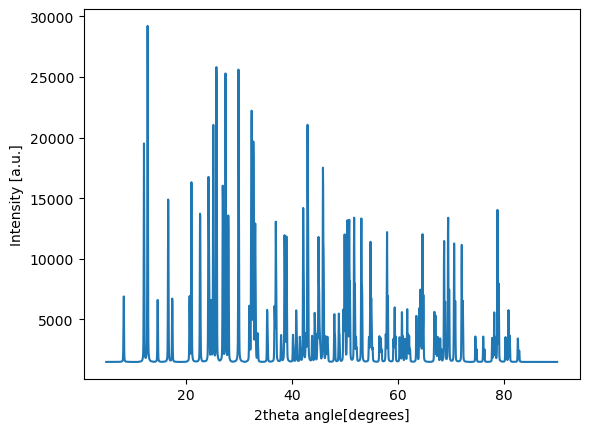

In [10]:
plt.plot(theor_arr[:,0],theor_arr[:,1],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

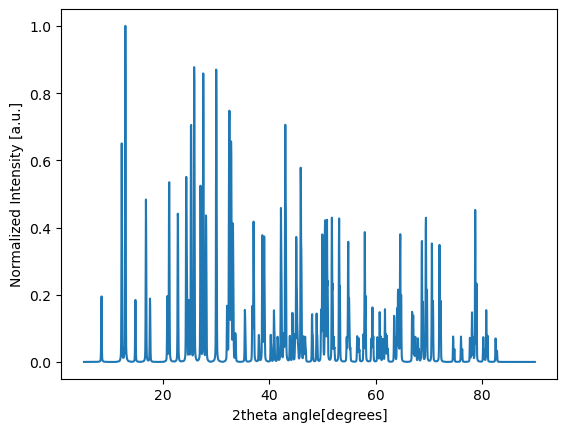

In [11]:
plt.plot(theor_arr[:,0],ntheor[:,0],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.show()

What is size of our theoretical XRD spectra

In [12]:
ntheor.shape

(2125, 164)

Let's have a look at the experimental spectra

In [13]:
exp.head(10)

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
0,0D,0D,0D,0D,0D,0D,0D,0D,0D,0D,...,3D,3D,3D,3D,3D,3D,3D,3D,3D,3D
1,5,1457,5,1657,5,1539,5,1374,5,1445,...,5,591,5,1041,5,641,5,5378,5,1412
2,5.04,1420,5.04,1654,5.04,1352,5.04,1348,5.04,1464,...,5.04,575,5.04,1058,5.04,627,5.04,5314,5.04,1408
3,5.08,1379,5.08,1650,5.08,1377,5.08,1358,5.08,1348,...,5.08,575,5.08,1038,5.08,591,5.08,5356,5.08,1451
4,5.12,1336,5.12,1594,5.12,1346,5.12,1403,5.12,1405,...,5.12,627,5.12,1047,5.12,599,5.12,5153,5.12,1418
5,5.16,1305,5.16,1583,5.16,1375,5.16,1332,5.16,1336,...,5.16,586,5.16,1001,5.16,563,5.16,5196,5.16,1375
6,5.2,1384,5.2,1598,5.2,1353,5.2,1355,5.2,1347,...,5.2,619,5.2,993,5.2,591,5.2,5402,5.2,1361
7,5.24,1364,5.24,1573,5.24,1352,5.24,1341,5.24,1352,...,5.24,602,5.24,980,5.24,598,5.24,5056,5.24,1301
8,5.28,1347,5.28,1572,5.28,1285,5.28,1298,5.28,1344,...,5.28,552,5.28,925,5.28,603,5.28,5118,5.28,1317
9,5.32,1398,5.32,1528,5.32,1299,5.32,1329,5.32,1384,...,5.32,573,5.32,945,5.32,597,5.32,5149,5.32,1349


We will do the same operation as what we have done for the theoretical data

In [14]:
#labels
exp_labels= exp.iloc[0]
#take out the first row
exp = exp.drop(exp.index[0])
#string to number
exp=exp.apply(pd.to_numeric, errors='coerce')
#dataframe to array
exp_arr=exp.values

#We didn't simulate the peak at 5.00 degrees, so start from 5.04
exp_arr=exp_arr[1:,:]

#normalization
ntheor = normdata (theor_arr)
nexp = normdata (exp_arr)

What is the shape of this matrix after normalization? (in other words, what are the available experimental data size?)

In [15]:
nexp.shape

(3248, 73)

## 2. Data preprocessing
### Trim the data
Since not all the data has the same range(2theta angles), we need to unify the range 

In [16]:
#define the range for spectrum (this is to unify the measurement range)
exp_min = 0
exp_max = 1350
theor_min = 0


We can plot  the measured spectra

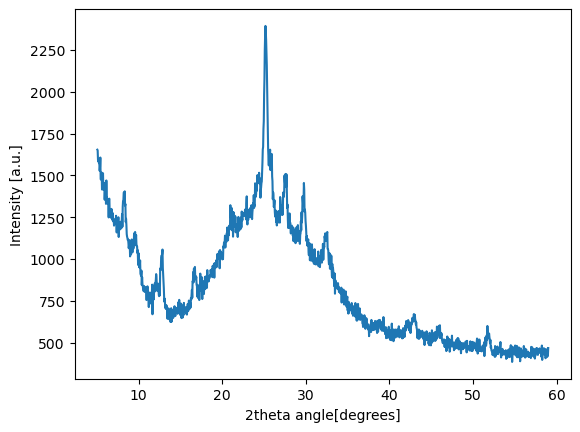

In [17]:
plt.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3],label='Experimental data')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

### Background and noise subtraction
window size is a hyperparamtere that we can change to determine the width of peaks. We call a function which is previously defined(exp_data_processing) to remove the measurement noise and signals from the substrate

In [23]:
#window size for experimental data extraction
window =15
theor_max = theor_min+exp_max-exp_min
#experimetal data input
post_exp= normdatasingle(exp_data_processing (nexp,exp_min,exp_max,window))

Let's plot the experimental spectra again after data post-processing

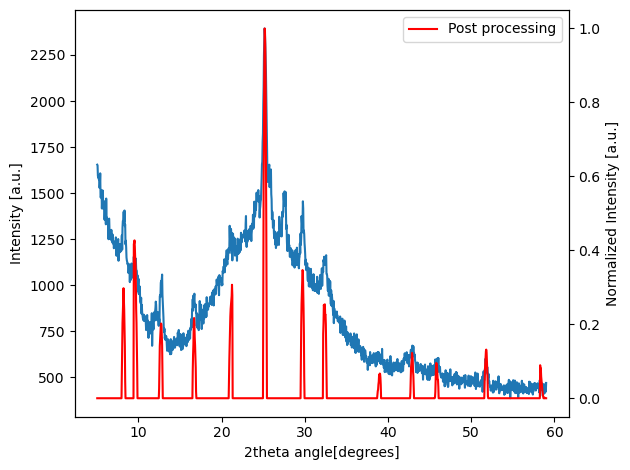

In [24]:
fig ,ax1 = plt.subplots()
ax1.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3])
ax1.set_xlabel('2theta angle[degrees]')
ax1.set_ylabel('Intensity [a.u.]')
ax2 = ax1.twinx()
ax2.plot(exp_arr[exp_min:exp_max,0],post_exp[:,1],color ='r')
ax2.set_ylabel('Normalized Intensity [a.u.]')
fig.tight_layout()
plt.legend(['Post processing'])
plt.show()

## 3. Data augmentation 

Let's augment the data for the theoretical dataset first

Specify how many data points we augmented for theoretical and experimental data

In [20]:
#let's start to do the data augmentation.
theor_aug_num = 1000
exp_aug_num = 1000
augd,pard,crop_augd = augdata(ntheor,theor_aug_num,theor,theor_min,theor_max,theor_labels)



Let's start from one theoretical spectra

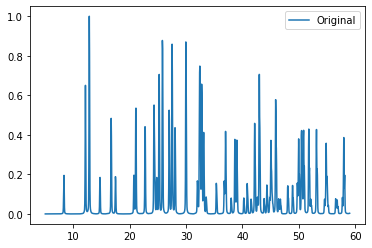

In [21]:
rnd = 0#np.random.randint(0,100)
demo_t = ntheor[theor_min:theor_max,(rnd)]
demo_x = theor_arr[theor_min:theor_max,0]
plt.plot(demo_x,demo_t,label='Original')
plt.legend(loc='upper right')
plt.show()

In [22]:
len(demo_x)

1350

Some peaks will not be visible due to preferred orientation, crystal size etc. We will add a periodic blocking filter which randomly eliminates peaks

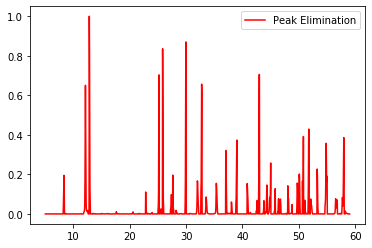

In [23]:
#add in the first filter (peak elimination)
dum1= np.repeat(np.random.choice([0,0,1],270),len(demo_x)//270)
demo_1st = np.multiply( demo_t,dum1)
#plot 
plt.plot(demo_x,demo_1st,label='Peak Elimination', color= 'r')
plt.legend(loc='upper right')
plt.show()

The relative intensities of those peaks also depends on the  preferred orientation . We will add another periodic filter that scales intensities randomly

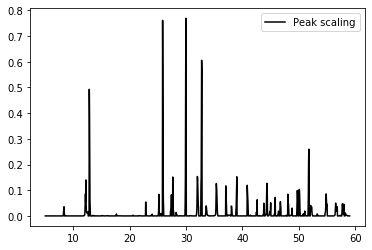

In [24]:
dum2= np.repeat(np.random.rand(135,),len(demo_x)//135)
demo_2nd = np.multiply( demo_1st,dum2)
#plot 
plt.plot(demo_x,demo_2nd,label='Peak scaling', color= 'k')
plt.legend(loc='upper right')
plt.show()           

Lastly, the strain and instrumental error may cause the shift of the spectra. We will shift the spectra within a limited range.

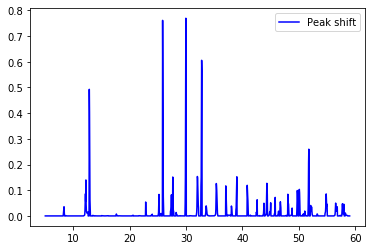

In [25]:
cut = np.random.randint(-20*1,20)
#XRD spectrum shift to left
if cut>=0:
    demo_3rd = np.append(demo_2nd[cut:,],np.zeros([cut,]))
#XRD spectrum shift to right
else:
    demo_3rd = np.append(demo_2nd[0:len(demo_x)+cut,],np.zeros([cut*-1,]))
#plot 
plt.plot(demo_x,demo_2nd,label='Peak shift', color= 'b')
plt.legend(loc='upper right')
plt.show()   
           


We can repeat this augmentation process many times for all spectra.

Now we  will augment the spectra both for experiment and theory from ~200 to 2000!

We should add labels to those augmented spectra 

In [26]:
#convert theorectical label from dimensionality to numbers
directory = ['0','2','3']
label_t=np.zeros([len(pard),])
for i in range(len(pard)): 
    temp = pard[i]
    label_t[i]=directory.index(temp[0])

#convert experimental label from dimensionality to numbers

par_exp = exp_labels

label_exp=np.zeros([len(par_exp)//2,])

for i in range(len(par_exp)//2):

    temp = par_exp[2*i]
    label_exp[i]=directory.index(temp[0])

## 4 Classification and cross validation using various ML algorithms

After data extraction, data preprocessing and data augmentation. We have ~2000 spectra now as an Input to train our machine learning algorithm. We can use part of those spectra to fine tune these hyperparameters and test the "untouched" spectra . The test  was done in the paper and will not be conducted here for the sake of time
Let's determine how many spectra we want to use to do a cross validation for our machine learning algorithm.

The Convolutional Neural Network(CNN) used in this demo is slightly modified from our paper (replace global average pooling layer with a fully connected layer) to shorten the training time. For the detailed structure and class activation maps(CAM), please refer to the space_group_a_CNN.py file in our repository.

In [27]:
#define the number of experimetal spectra we use for a N flold cross validation
exp_num =70
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]
#train and test split for the experimental data
#X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp
      #  ,y_exp , test_size=0.33,random_state=1)



#train and test split for the theorectical data
X_th = np.transpose(crop_augd )
y_th = label_t
#X_train_th, X_test_th, y_train_th, y_test_th = train_test_split( 
       # X_th, y_th, test_size=0.33,random_state=1)


#convert the labels to onehot encoder
enc = OneHotEncoder(sparse=False)

y_th_onehot = enc.fit_transform(y_th .reshape(-1,1))

y_exp_onehot = enc.transform(y_exp.reshape(-1,1))


Split the data to N folds ---(N-1)/N% training, 1/N% test) 

In [28]:
n_fold = 5
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)

choose your favorate machine learning algorithem

In [29]:
test_classifier = ['CNN']
classifiers = {'NB':naive_bayes_classifier,   
                   'KNN' :knn_classifier,                      
                   'RF':random_forest_classifier,  
                   'DT':decision_tree_classifier,  
                   'SVM':svm_classifier,                    
                   'GBDT':gradient_boosting_classifier,
                   'NN':mlp_classifier,
                   'CNN': CNN
                   
    }  

In [30]:
K.backend.clear_session()
accuracy_exp = np.empty((n_fold,1)) 
start_time = time.time()   
for classifier in test_classifier: 
    print ('******************* %s ********************' % test_classifier)
    for k, (train, test) in enumerate(k_fold.split(X_exp, y_exp)):       
           
            #data augmentation to experimenal traning dataset
            temp_x = X_exp[train]
            temp_y = y_exp[train]
            exp_train_x,exp_train_y = exp_augdata(temp_x.T,exp_aug_num ,temp_y)
            #combine theorectical and experimenal dataset for training
            train_combine = np.concatenate((X_th,exp_train_x.T))
            train_y = np.concatenate((y_th,exp_train_y))                                 
    
            #predict experimental prediction accuracy
            if classifier == 'CNN':
                train_y = enc.transform(train_y.reshape(-1,1))
                model = classifiers[classifier](train_combine, train_y) 
                predict_exp = model.predict(np.expand_dims(X_exp[test],2))
                predict_exp = enc.inverse_transform(predict_exp)
            else:
                model = classifiers[classifier](train_combine, train_y) 
                predict_exp = model.predict(X_exp[test])
            
            accuracy_exp[k] = accuracy_score(y_exp[test], predict_exp)  
            print ('accuracy_exp: %.2f%%' % (100 * accuracy_exp[k]))
            # 5 fold cross validation



******************* ['CNN'] ********************
Epoch 1/15
2000/2000 [==============================] - 2s 896us/step - loss: 0.5572 - categorical_accuracy: 0.5735
Epoch 2/15
2000/2000 [==============================] - 0s 96us/step - loss: 0.3970 - categorical_accuracy: 0.7415
Epoch 3/15
2000/2000 [==============================] - 0s 95us/step - loss: 0.2919 - categorical_accuracy: 0.8185
Epoch 4/15
2000/2000 [==============================] - 0s 100us/step - loss: 0.2555 - categorical_accuracy: 0.8405
Epoch 5/15
2000/2000 [==============================] - 0s 95us/step - loss: 0.2161 - categorical_accuracy: 0.8745
Epoch 6/15
2000/2000 [==============================] - 0s 106us/step - loss: 0.1982 - categorical_accuracy: 0.8785
Epoch 7/15
2000/2000 [==============================] - 0s 96us/step - loss: 0.1857 - categorical_accuracy: 0.8945
Epoch 8/15
2000/2000 [==============================] - 0s 102us/step - loss: 0.1700 - categorical_accuracy: 0.8975
Epoch 9/15
2000/2000 [=====

accuracy_exp: 78.57%
Epoch 1/15
2000/2000 [==============================] - 0s 193us/step - loss: 0.5620 - categorical_accuracy: 0.5610
Epoch 2/15
2000/2000 [==============================] - 0s 137us/step - loss: 0.4310 - categorical_accuracy: 0.6895
Epoch 3/15
2000/2000 [==============================] - 0s 101us/step - loss: 0.3060 - categorical_accuracy: 0.8125
Epoch 4/15
2000/2000 [==============================] - 0s 100us/step - loss: 0.2517 - categorical_accuracy: 0.8395
Epoch 5/15
2000/2000 [==============================] - 0s 119us/step - loss: 0.2171 - categorical_accuracy: 0.8745
Epoch 6/15
2000/2000 [==============================] - 0s 104us/step - loss: 0.1949 - categorical_accuracy: 0.8810
Epoch 7/15
2000/2000 [==============================] - 0s 94us/step - loss: 0.1846 - categorical_accuracy: 0.8865
Epoch 8/15
2000/2000 [==============================] - 0s 105us/step - loss: 0.1683 - categorical_accuracy: 0.9000
Epoch 9/15
2000/2000 [==============================

In [31]:
print ('CV  took %fs!' % (time.time() - start_time) )
print('Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_exp), np.mean(np.abs(accuracy_exp))))

CV  took 26.238970s!
Cross-validation results:
Folds: 5, mean acc: 0.900


## 5 Hyper parameter tunning 

We can fine tune the hyperparameters in both the classifers and data preproessing&augmentation for each method we tried. Appoaches such as Grid search,randomized search or Bayesian Optimization can be used. Detailed info can be found here:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

We find a three layer CNN performs better than other classifiers for both cross validation and newly synthezied validation dataset.